# Fine Control the Evolution Process

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/pyglove/blob/main/docs/notebooks/intro/search/evolution_scheduling.ipynb)

Oftentimes, we may want to adjust reproduction behaviors while evolution progresses. For example, to explore more at the beginning, and to exploit more at the later stage of the search. This notebook illustrates how to fine control such behaviors during the evolution process, through PyGlove's symbolic scalar system. In fact, almost all built-in operations provided by PyGlove support hyperparameters controlled by such scalars. Before we get into a rich library of scalars, let's start with a simple case which decays the mutation probability as the search progresses.

In [ ]:
!pip install pyglove

In [4]:
import pyglove as pg

<a name="getting-started"></a>
## Getting Started: Mutation with decaying probability

First, let's mutate a DNA with the same probability (0.9) along the whole evolution process:

In [5]:
dna_spec = pg.dna_spec(pg.oneof(range(10)))
dna = dna_spec.first_dna()
print(dna)

DNA(0)


In [6]:
# Mutate a DNA with prability 0.9.
op = pg.evolution.mutators.Uniform(seed=1).with_prob(0.9)
for _ in range(10):
  dna = op([dna])[0]
  print(dna)

DNA(9)
DNA(4)
DNA(7)
DNA(7)
DNA(3)
DNA(7)
DNA(6)
DNA(9)
DNA(7)
DNA(3)


Assume we will run the search with 20 generations, can we gradually reduce the mutation probability from 1.0 to 0.0? Here is the answer:

In [7]:
op = pg.evolution.mutators.Uniform(seed=1).with_prob(
    pg.scalars.linear(20, 1.0, 0.0), seed=1)

dna = dna_spec.first_dna()
for i in range(20):
  dna = op([dna], step=i)[0]
  print(dna)

DNA(9)
DNA(4)
DNA(7)
DNA(7)
DNA(3)
DNA(7)
DNA(6)
DNA(6)
DNA(9)
DNA(7)
DNA(7)
DNA(3)
DNA(3)
DNA(5)
DNA(5)
DNA(5)
DNA(5)
DNA(5)
DNA(5)
DNA(0)


<a name="scalar-system"></a>
## PyGlove's Symbolic Scalar System

Before we introduce PyGlove's symbolic scalar system, let's take a look at the mechanism for supporting evolution behavior scheduling.

<a name="step-based-hyper"></a>
### Step-based Hyperparameters

As introduced in [Evolutionary Algorithm](https://colab.research.google.com/github/google/pyglove/blob/main/docs/notebooks/intro/search/evolution_algorithm.ipynb), evolutionary operations in PyGlove can take a `step` argument when processing the input. This means, if an operation is controlled by a hyperparameter (e.g. probability), the hyperparameter can be a function of `step`. Therefore, we can pass a function to `pg.evolution.selectors.Top` as the value for `n`:



In [8]:
dna_list = [
  pg.evolution.set_fitness(pg.DNA(i), i)
  for i in range(10)
]

In [9]:
op = pg.evolution.selectors.Top(lambda x: x)

print(op(dna_list, step=0))
print(op(dna_list, step=1))
print(op(dna_list, step=2))

[]
[DNA(9)]
[DNA(9), DNA(8)]


<a name="symbolic-scalars"></a>
### Symbolic Scalars: Reusable & compositional functions for hyperparameter scheduling

It's natural to think about how to make the functions for producing hyperparameters reusable, preferrably compositional. PyGlove introduces `pg.scalars` sub-module for such purpose. A scalar is a callable symbolic object that produces a value based on a step, defined as:

```python
class Scalar(pg.Object):
  def __call__(self, step: int) -> Any
```

For example, `pg.scalars.STEP` is a singleton `Scalar` subclass which returns the current step. `Scalar` overloads operators such as `__add__`, `__sub__`, so the scalar objects can be combined as regular math expressions. For example:

In [10]:
h = (pg.scalars.Constant(2) 
     + pg.scalars.linear(total_steps=10, start=0, end=10))
print(h)
print(h(10))

Addition(
  x = Constant(
    value = 2
  ),
  y = Addition(
    x = 0,
    y = Multiplication(
      x = _Step(),
      y = 1.0
    )
  )
)
12.0


In order for an operation to use a scalar as hyperparameter, all it needs is to:
 * define its hyperparameter using `pg.scalars.scalar_spec`.
 * get the scalar value at a given step using `pg.scalars.scalar_value`.
 
For example, `pg.evolution.selectors.Top` defines and consumes its argument `n` in the following way:

```python
@pg.mebmers([
  ('n', pg.scalars.scalar_spec(pg.typing.Int(min_value=0)))
])
class Top(pg.evolution.Selector)
  def select(self, inputs, step):
    n = pg.scalars.scalar_value(self.n, step)
    ...
```

<a name="catalog"></a>
## A Catalog of Built-in Scalars

PyGlove provides a rich set of built-in scalars for addressing most common scheduling needs, including basic math operations, random number generators and common decay functions. It also provides a `StepWise` schedule to work with `pg.evolution.Conditional` operator to generate complex evolution processes.



In [11]:
import matplotlib.pyplot as plt

def render_scalar(scalar, steps=100):
  ys = [scalar(step=i) for i in range(1, steps + 1)]
  plt.plot(ys)

<a name="basic-scalars"></a>
### Basic Scalars

<a name="step"></a>
#### **STEP**: Returns current step

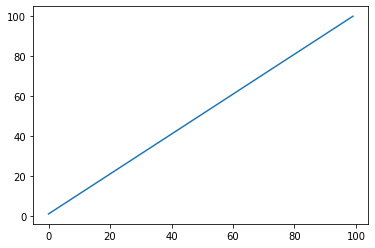

In [12]:
s = pg.scalars.STEP
render_scalar(s)

<a name="lambda"></a>
#### **Lambda**: Converts a function into a scalar

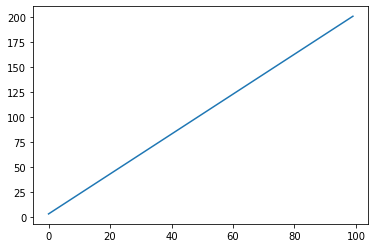

In [13]:
s = pg.scalars.Lambda(lambda step: step * 2) + 1
render_scalar(s)

<a name="constant"></a>
#### **Constant**: Returns a constant as scalar

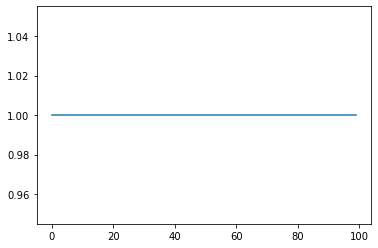

In [14]:
s = pg.scalars.Constant(1)
render_scalar(s)

<a name="step-wise"></a>
#### **StepWise**: Step-wise scalar

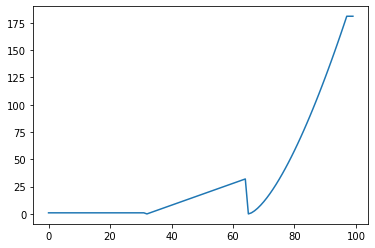

In [15]:
s = pg.scalars.StepWise([
    (0.2, 1),
    # pg.scalars.STEP means step within current phase
    # in the context of step-wise scalar.
    (0.2, pg.scalars.STEP),
    (0.2, pg.scalars.STEP ** 1.5),
], total_steps=100)
render_scalar(s)

<a name="math-exps"></a>
### Math Expressions

<a name="common-math-ops"></a>
#### Common Math Operations

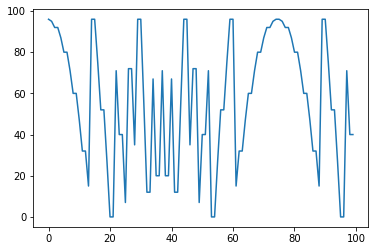

In [16]:
s = (-(pg.scalars.STEP * 2 // 3) ** 2 - 5 + 1) % 100
render_scalar(s)

<a name="ceiling"></a>
#### **Ceiling**: Returns ceil(x)

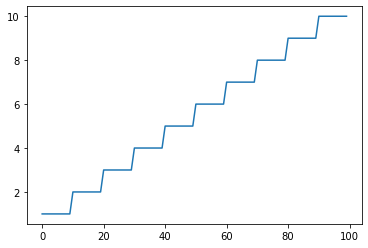

In [17]:
s = pg.scalars.Ceiling(pg.scalars.STEP / 10)
render_scalar(s)

<a name="floor"></a>
#### **Floor**: Returns floor(x)

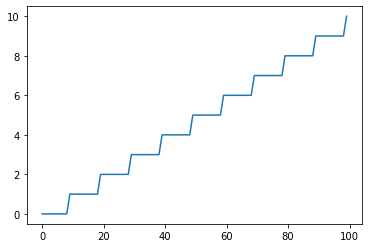

In [18]:
s = pg.scalars.Floor(pg.scalars.STEP / 10)
render_scalar(s)

<a name="sqrt"></a>
#### **SquareRoot/sqrt**: Returns sqrt(x)

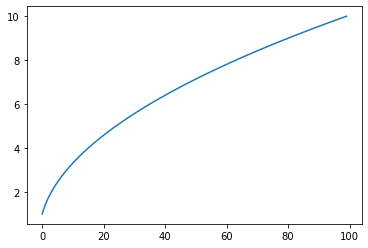

In [19]:
s = pg.scalars.sqrt(pg.scalars.STEP)
render_scalar(s)

<a name="log"></a>
#### **Log/log**: Returns log(x)

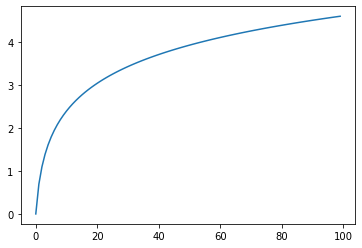

In [20]:
s = pg.scalars.log(pg.scalars.STEP)
render_scalar(s)

<a name="exp"></a>
#### **Exp/exp**: Returns exp(x)

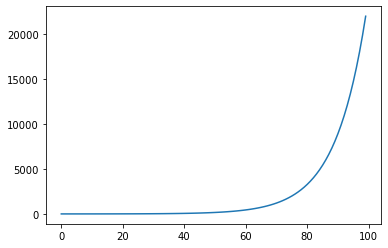

In [21]:
s = pg.scalars.exp(pg.scalars.STEP / 10)
render_scalar(s)

<a name="sin"></a>
#### **Sine/sin**: Returns sine(x)

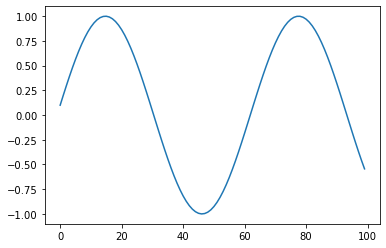

In [22]:
s = pg.scalars.sin(pg.scalars.STEP / 10)
render_scalar(s)

<a name="cos"></a>
#### **Cosine/cos**: Returns Cosine(x)

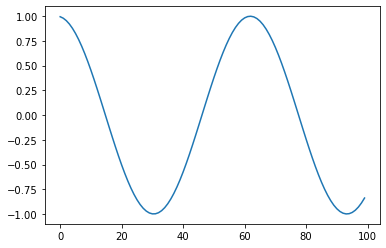

In [23]:
s = pg.scalars.cos(pg.scalars.STEP / 10)
render_scalar(s)

<a name="decay-helpers"></a>
### Common Decay Helpers

<a name="linear"></a>
#### **Linear**: Linear scaling based on STEPS

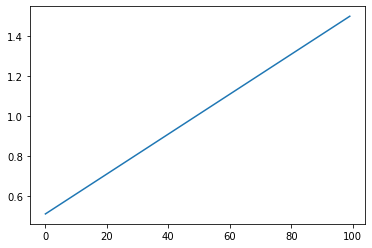

In [24]:
s = pg.scalars.linear(100, 0.5, 1.5)
render_scalar(s)

<a name="exponential"></a>
#### **Exponential Decay**: Exponential scaling based on STEPS

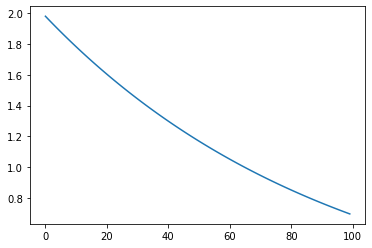

In [25]:
s = pg.scalars.exponential_decay(
    decay_rate=0.9, decay_interval=10, start=2.0, staircase=False)
render_scalar(s)

<a name="cos-decay"></a>
#### **Cosine Decay**: Cosine decay based on STEPS

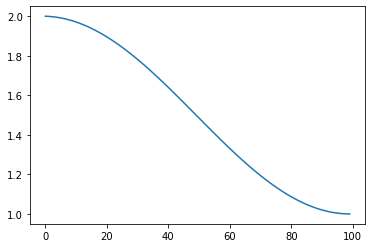

In [26]:
s = pg.scalars.cosine_decay(
    total_steps=100, start=2.0, end=1.0)
render_scalar(s)

<a name="cyclic"></a>
#### **Cyclic**: Cyclic scaling based on STEPS

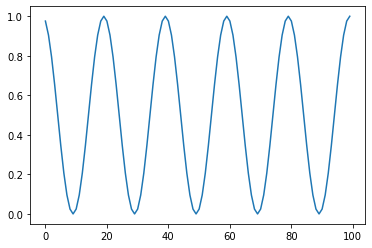

In [27]:
s = pg.scalars.cyclic(cycle=20)
render_scalar(s)

<a name="random"></a>
### Random Numbers

In [28]:
def render_distribution(scalar, steps=1000):
  plt.hist([scalar(step=i) for i in range(1, steps + 1)])

<a name="uniform"></a>
#### **Uniform**: Returns a random number in uniform distribution.

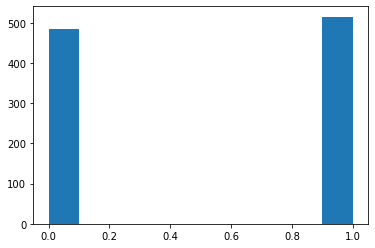

In [29]:
# Returns a random int from a range.
s = pg.scalars.Uniform(0, 1, seed=1)
render_distribution(s)

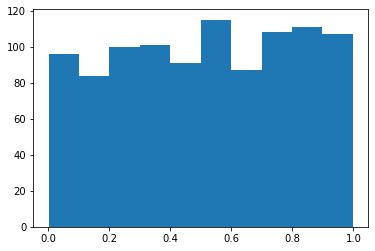

In [30]:
# Returns a random float from a range.
s = pg.scalars.Uniform(0.0, 1.0, seed=1)
render_distribution(s)

<a name="triangular"></a>
#### **Triangular**: Returns a random float number in triangular distribution.

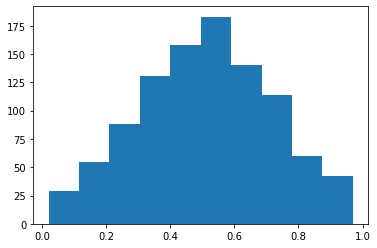

In [31]:
s = pg.scalars.Triangular(0.0, 1.0, seed=1)
render_distribution(s)

<a name="gaussian"></a>
#### **Gaussian**: Returns a random float number in gaussian distribution.

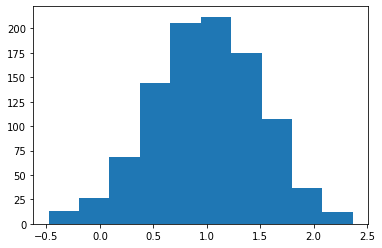

In [32]:
s = pg.scalars.Gaussian(mean=1.0, std=0.5, seed=1)
render_distribution(s)

<a name="normal"></a>
#### **Normal**: Returns a random float number in normal distribution.

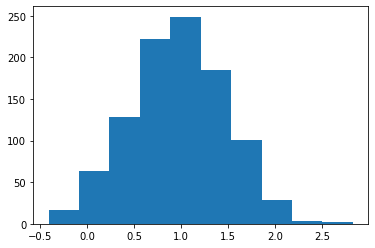

In [33]:
s = pg.scalars.Normal(mean=1.0, std=0.5, seed=1)
render_distribution(s)

<a name="log-normal"></a>
#### **LogNormal**: Returns a random float number in log normal distribution.

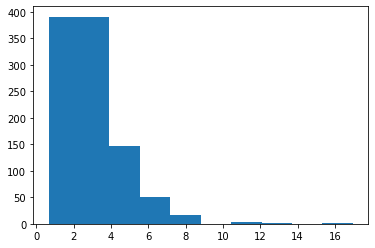

In [34]:
s = pg.scalars.LogNormal(mean=1.0, std=0.5, seed=1)
render_distribution(s)